In [1]:
# @title Library Installation

print("Updating pip...")
!pip install --upgrade pip

print("Installing torch and CUDA dependencies...")
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

print("Installing flash-attention and bitsandbytes...")
!pip install -U flash-attn --no-build-isolation
!pip install bitsandbytes --upgrade

print("Installing Hugging Face Transformers and Accelerate...")
!pip install -U transformers accelerate

print("Installing other necessary libraries...")
!pip install pandas numpy matplotlib seaborn scikit-learn google-generativeai pillow requests anthropic tensorflow qwen-vl-utils

print("Installation completed.")

Updating pip...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Installing torch and CUDA dependencies...
Looking in indexes: https://download.pytorch.org/whl/cu124
Installing flash-attention and bitsandbytes...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 107.8 MB/s  0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'flash-attn' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'flash-attn'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for flash-attn: fi

In [2]:
!pip install transformers==4.48.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 68.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 129.4 MB/s  0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.0
    Uninstalling tokenizers-0.22.0:
      Successfully uninstalled tokenizers-0.22.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.2
    Uninstalling transformers-4.56.2:
      Successfully uninstalled transformers-4.56.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [transformers]


In [3]:
# @title Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import pipeline

from PIL import Image

import requests
from io import BytesIO
import base64
import os
import torch
import anthropic

from qwen_vl_utils import process_vision_info

from huggingface_hub import login
from google.colab import userdata
import google.generativeai as genai

import re
from datetime import datetime
import sys
import xml.etree.ElementTree as ET
import time
import json
from functools import partial
import traceback

print("Imports completed.")

Imports completed.


In [4]:
from transformers import  AutoProcessor, AutoModelForCausalLM

In [5]:
import transformers
print(transformers.__version__)

4.48.0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)

In [8]:
ruta = '/content/drive/MyDrive/Colab Notebooks/DatasetV1/datasetV1.csv'
df = pd.read_csv(ruta, encoding='utf-8')

print(df.head())

                                                 url  \
0  http://bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3...   
1  http://bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bj...   
2  http://bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgq...   
3              http://01anjali2001.github.io/netflix   
4  http://bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj...   

                                        html_content  \
0  0001_bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3td...   
1  0002_bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpd...   
2  0003_bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtu...   
3      0004_01anjali2001.github.io_netflix/page.html   
4  0005_bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj5a...   

                                          screenshot  label  
0  0001_bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3td...      1  
1  0002_bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpd...      1  
2  0003_bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtu...      1  
3  0004_01anjali2001.github.io_netflix/screenshot...      1  
4  0005_bafybeid

In [9]:
df.dropna(inplace=True)

In [10]:
print(df.info())

print(df.describe())

print(df.isnull().sum())

if 'label' in df.columns:
    print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           1000 non-null   object
 1   html_content  1000 non-null   object
 2   screenshot    1000 non-null   object
 3   label         1000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None
           label
count  1000.0000
mean      0.8000
std       0.4002
min       0.0000
25%       1.0000
50%       1.0000
75%       1.0000
max       1.0000
url             0
html_content    0
screenshot      0
label           0
dtype: int64
label
1    800
0    200
Name: count, dtype: int64


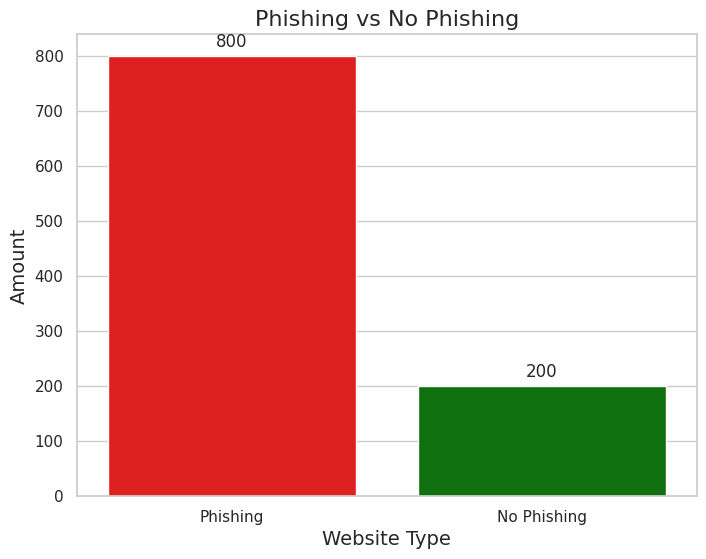

In [11]:
label_map = {0: 'No Phishing', 1: 'Phishing'}

df['label_name'] = df['label'].map(label_map)

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label_name', data=df, hue='label_name', palette={'No Phishing': 'green', 'Phishing': 'red'}, legend=False)

plt.title('Phishing vs No Phishing', fontsize=16)
plt.xlabel('Website Type', fontsize=14)
plt.ylabel('Amount', fontsize=14)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12)
plt.show()

In [12]:
def prompt_option1_all(html_content: str, screenshot, url):
    prompt = [
        {
            "role": "user",
            "content":
                    """
                    <|image_1|>\n Act as a professional cybersecurity specialist reviewing websites to determinate if they are fishing or not. You will receive a URL, the HTML of the website and a screenshot.
                    Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name
                    """
                    f"URL: {url}\n"
                    f"HTML extract: {html_content[:5000]}"


        }
    ]
    return prompt

In [13]:
def prompt_option2_all(html_content: str, screenshot, url):
    prompt = [
        {
            "role": "user",
            "content":
                    """
                    <|image_1|>\n Act as a professional cybersecurity specialist reviewing websites to determinate if they are fishing or not. You will receive a URL, the HTML of the website and a screenshot.
                    Consider:
                      1.Identification of the main brand the page is attempting to represent
                      2.Suspicious elements (credential fields, urgent calls to action)
                      3.Consistency between the identified brand and the displayed domain
                      4.Typical visual characteristics of phishing (low-quality logos, typographical errors)
                    Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name
                    """
                    f"URL: {url}\n"
                    f"HTML extract: {html_content[:5000]}"


        }
    ]
    return prompt

In [14]:
def prompt_option3_all(html_content: str, screenshot, url):
    prompt = [
        {
            "role": "user",
            "content":
                    """
              <|image_1|>\n [Context] You are a professional cybersecurity specialist reviewing websites to determinate if they are fishing or not. You will receive a URL, the HTML of the website and a screenshot.
              Follow this process:

                  Visual Analysis:
                      Identify the main visual elements (logos, colors, structure)
                      Look for inconsistencies in the design or low-quality elements
                      Detect any fields for entering sensitive data

                  Content Analysis:
                      Extract the main text and analyze its tone and content
                      Look for urgent language or threats
                      Verify consistency with the supposed brand

                  URL Analysis:
                      Examine the domain and compare it with the identified brand
                      Look for suspicious characters or typosquatting techniques

                  Conclusion:
                      Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name

              """
                    f"URL: {url}\n"
                    f"HTML extract: {html_content[:5000]}"

        }
    ]
    return prompt

In [15]:
def prompt_option1_url(html_content: str, screenshot, url):

    prompt = [
        {
            "role": "user",
            "content":
                     """
                    <|image_1|>\n Act as a professional cybersecurity specialist reviewing websites to determine if they are phishing or not. You will receive a URL.
                    Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name.
                    """
                    f"URL: {url}"

        }
    ]
    return prompt

In [16]:
def prompt_option2_url(html_content: str, screenshot, url):
    """
    Constructs the Checklist-augmented Persona prompt for the URL-Only task (LLAVA style).
    Ignores html_content and screenshot in the prompt content.
    """
    prompt = [
        {
            "role": "user",
            "content":
                     """
                      <|image_1|>\n Act as a professional cybersecurity specialist reviewing websites to determine if they are phishing or not. You will receive a URL.
                      Consider the following aspects of the URL:
                        1. Suspicious domain name (typosquatting, unexpected Top-Level Domain, use of IP addresses)
                        2. Subdomain structure and depth
                        3. Length and complexity of the URL string
                        4. Presence of deceptive elements (e.g., brand names in subdomains or paths)

                      Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name.
                      """
                      f"URL: {url}"
        }
    ]
    return prompt

In [17]:
def prompt_option3_url(html_content: str, screenshot, url):
    """
    Constructs the Structured Analysis prompt for the URL-Only task (LLAVA style).
    Ignores html_content and screenshot in the prompt content.
    """
    prompt = [
        {
            "role": "user",
            "content":
                    """
                    <|image_1|>\n [Context] You are a professional cybersecurity specialist reviewing websites to determine if they are phishing or not. You will receive a URL.
                    Follow this process to analyze the URL:

                        URL Analysis:
                            Examine the main domain, looking for signs of typosquatting or unusual Top-Level Domains.
                            Analyze the subdomain structure for excessive depth or suspicious names.
                            Check if an IP address is used instead of a human-readable domain name.
                            Review the path and query string for obfuscation, unusual characters, or deceptive elements.

                        Conclusion:
                            Based on the URL analysis, classify the website as "Phishing" or "Legitimate". Just respond with the class name.

                    """
                    f"URL: {url}"

        }
    ]
    return prompt

In [18]:
def prompt_option1_screenshot(html_content: str, screenshot, url):
    """
    Constructs the Structured Analysis User prompt for the HTML-Only task.
    Ignores screenshot and url.
    """
    prompt = [
        {
            "role": "user",
            "content":
                    """
                    <|image_1|>\n Act as a professional cybersecurity specialist analyzing website screenshots to detect phishing.
                    You will receive a screenshot of a webpage. Classify it as "Phishing" or "Legitimate" based ONLY on visual elements.
                    Respond strictly with one word: 'Phishing' or 'Legitimate'.
                    """
        }
    ]
    return prompt

In [19]:
def prompt_option2_screenshot(html_content: str, screenshot, url):
    """
    Constructs the Structured Analysis User prompt for the HTML-Only task.
    Ignores screenshot and url.
    """
    prompt = [
        {
            "role": "user",
            "content":
                   """
                    <|image_1|>\n As a cybersecurity expert, analyze website screenshots using these visual indicators:
                    1. Poor design quality or imitation of legitimate brands
                    2. Suspicious login/credit card forms
                    3. Urgency warnings or threat messages
                    4. Mismatched logos/branding elements
                    5. Missing security indicators (padlock, trust seals)
                    6. Unprofessional layout or pixelated assets

                    Based on this analysis, classify the website and respond strictly with one word: 'Phishing' or 'Legitimate'
                  """
        }
    ]
    return prompt

In [20]:
def prompt_option3_screenshot(html_content: str, screenshot, url):
    """
    Constructs the Structured Analysis User prompt for the HTML-Only task.
    Ignores screenshot and url.
    """
    prompt = [
        {
            "role": "user",
            "content":
                    """
                <|image_1|>\n [Context] You are a professional cybersecurity specialist reviewing websites to determine if they are phishing or not. You will receive a screenshot of a webpage.
                Follow this process to analyze the screenshot:

                    Screenshot Analysis:
                        1. Brand Consistency: Check logos, colors, and typography
                        2. Form Analysis: Identify input fields and their context
                        3. Security Indicators: Verify padlock icons, SSL cues
                        4. Content Quality: Assess language errors and image quality
                        5. Urgency Cues: Detect warnings or time-sensitive demands

                    Conclusion:
                        Based on the screenshot analysis, classify the website as "Phishing" or "Legitimate". Just respond with the class name.
                """
        }
    ]
    return prompt

In [21]:
def prompt_option1_html(html_content: str, screenshot, url):
    """
    Constructs the Zero-shot User prompt for the HTML-Only task.
    Ignores screenshot and url.
    """
    prompt = [
        {
            "role": "user",
            "content":
                    """
                    <|image_1|>\n Act as a professional cybersecurity specialist reviewing websites to determine if they are phishing or not. You will receive HTML content.
                    Based on the HTML analysis, classify the website as "Phishing" or "Legitimate". Just respond with the class name.
                    """
                    f"HTML: {html_content[:5000]}"
        }
    ]
    return prompt

In [22]:
def prompt_option2_html(html_content: str, screenshot, url):
    """
    Constructs the Checklist-augmented User prompt for the HTML-Only task.
    Ignores screenshot and url.
    """
    prompt = [
        {
            "role": "user",
            "content":
                    """
                    <|image_1|>\n Act as a professional cybersecurity specialist reviewing websites to determine if they are phishing or not. You will receive HTML content.
                    Consider the following aspects of the HTML:
                        1. Suspicious form fields (password/credit card inputs)
                        2. Poor design quality or imitation of legitimate brands
                        3. Urgency-creating language or threats
                        4. Mismatched links (href vs displayed text)
                        5. Lack of legitimate contact information
                        6. Suspicious scripts or iframes

                    Based on this analysis, classify the website as "Phishing" or "Legitimate". Just respond with the class name.
                    """
                    f"HTML: {html_content[:5000]}"
        }
    ]
    return prompt


In [23]:
def prompt_option3_html(html_content: str, screenshot, url):
    """
    Constructs the Structured Analysis User prompt for the HTML-Only task.
    Ignores screenshot and url.
    """
    prompt = [
        {
            "role": "user",
            "content":
                    """
                    <|image_1|>\n [Context] You are a professional cybersecurity specialist reviewing websites to determine if they are phishing or not. You will receive HTML content.
                    Follow this process to analyze the HTML:

                        HTML Analysis:
                            1. Examine the forms for sensitive data collection
                            2. Check for brand impersonation in logos/text
                            3. Analyze the quality of content and design
                            4. Verify link consistency (displayed vs actual URLs)
                            5. Look for suspicious scripts or external resources
                            6. Check for presence/absence of security indicators

                        Conclusion:
                            Based on the HTML analysis, classify the website as "Phishing" or "Legitimate". Just respond with the class name.
                    """
                    f"HTML: {html_content[:5000]}"
        }
    ]
    return prompt

In [24]:
def _load_row_data(row: pd.Series, base_path: str):
    """
    Loads and prepares HTML content and a screenshot from a given row of a DataFrame.

    Args:
        row (pd.Series): A row from a DataFrame containing 'html_content' and 'screenshot' file paths.
        base_path (str): The base directory where the files are located.

    Returns:
        tuple: A tuple containing the HTML content (str) and the prepared screenshot (PIL.Image).
    """
    html_path = os.path.join(base_path, row['html_content'])
    screenshot_path = os.path.join(base_path, row['screenshot'])

    # Read HTML content
    with open(html_path, 'r', encoding='utf-8') as file:
        html_content = file.read()

    # Load and prepare image
    screenshot = Image.open(screenshot_path).convert('RGB')
    if screenshot is None:
        raise ValueError(f"Could not load the image: {screenshot_path}")
    screenshot = screenshot.resize((512, 512))  # Resize

    return html_content, screenshot

In [25]:
def _generate_response(model, messages, processor, screenshot):
    """
    Generates a response from a multi-modal model based on a list of messages and an image.

    Args:
        model: The multi-modal model instance.
        messages (list): A list of dictionaries representing the chat history.
        processor: The processor for the model (tokenization and image processing).
        screenshot: A PIL Image object of the screenshot.

    Returns:
        str: The generated text response from the model.

    Raises:
        Exception: If an error occurs during the generation process.
    """
    try:
        # 1. Apply the chat template
        # This converts the `messages` list of dictionaries into a single string
        # that the model expects as input.
        prompt = processor.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )

        # 2. Process the prompt and image to get the inputs
        # The processor takes the text and image separately.
        inputs = processor(
            text=prompt,
            images=[screenshot],  # This line can be removed if you only want to analyze text.
            return_tensors="pt"
        ).to(model.device)

        # 3. Generate the response
        generation_args = {
            "max_new_tokens": 512,  # You can adjust this
            "temperature": 0.0,
            "do_sample": False,
        }

        generate_ids = model.generate(
            **inputs,
            eos_token_id=processor.tokenizer.eos_token_id,
            **generation_args
        )

        # 4. Decode the response
        # We only decode the tokens generated by the model, not the input tokens.
        generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
        response = processor.batch_decode(
            generate_ids,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False
        )[0]

        return response

    except Exception as e:
        print(f"❌ Error generating response: {type(e).__name__} - {e}")
        return f"Error: {type(e).__name__} - {e}"

In [30]:
def _configure_model(model_id: str):
    """
    Configures and loads a language model and its processor for inference.

    Args:
        model_id (str): The identifier of the model to load (e.g., 'qwen/Qwen-VL').

    Returns:
        tuple: A tuple containing the loaded model, its processor, and the configuration.

    Raises:
        ValueError: If the provided model_id is not found in the configuration dictionary.
    """
    print(f"⚡ Configuring and loading pipeline for {model_id}...")

    torch.cuda.empty_cache()

    # Load the model from a pre-trained checkpoint
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="cuda",
        trust_remote_code=True,
        torch_dtype="auto",
        attn_implementation='flash_attention_2'
    )

    # Load the processor (tokenizer and image processor)
    processor = AutoProcessor.from_pretrained(
        model_id,
        trust_remote_code=True,
        num_crops=4
    )

    return model, processor

In [35]:
def _process_row(row: pd.Series, model, processor, base_path: str, output_filepath: str, prompt_method_to_use):
    """
    Processes a single row from the DataFrame: loads data, builds the prompt, and generates a response.

    Args:
        row (pd.Series): The row of the DataFrame to process.
        model: The loaded language model.
        processor: The model's processor (tokenizer, image processor).
        base_path (str): The base directory for data files.
        output_filepath (str): The path to the output log file.
        prompt_method_to_use: The function to use for building the prompt.

    Returns:
        str: The generated text response from the model, or an error message.
    """
    url = row.get('url', 'URL unknown')
    label = row.get('label', 'Label unknown')
    label_text = "PHISHING (true)" if label == 1 else "SAFE (false)"
    try:
        # 1. Load data
        html_content, screenshot = _load_row_data(row, base_path)

        # 2. Build prompt
        messages = prompt_method_to_use(html_content, screenshot, url)

        # 3. Generate Response
        generated_text = _generate_response(model, messages, processor, screenshot)

        # 4. Log output
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"--- FULL Output for URL: {url} {label_text} ({timestamp}) ---")
        print(generated_text)
        print(f"--- End of Full Output ---")

        try:
            # Open the file in append mode ('a') with utf-8 encoding
            with open(output_filepath, 'a', encoding='utf-8') as f:
                f.write(f"URL: {url}\n")
                f.write(f"\nExpected Result: {label_text}\n")
                f.write(f"Output: {generated_text}\n\n")
        except IOError as e:
            print(f"❌ Error writing to file {output_filepath} for {url}: {e}")

        # 5. Return the result for the 'prediction' column
        # (Consider if you need to parse the XML here or later)
        return generated_text

    except FileNotFoundError as e:
        print(f"❌ Error - File not found for {url}: {e}")
        return f"Error: File not found ({e.filename})"
    except ValueError as e:
        print(f"❌ Error - Invalid value (e.g., image loading) for {url}: {e}")
        return f"Error: {e}"
    except Exception as e:
        # Generic catch for other unexpected errors during row processing
        print(f"❌ Unexpected error processing {url}: {type(e).__name__} - {e}")
        return "Analysis Error"

In [34]:
def classifier(model_id: str, df: pd.DataFrame, base_path: str, output_filepath: str, prompt_method_to_use):
    """
    Main function to classify a DataFrame using a specified model and prompting method.

    Args:
        model_id (str): Identifier for the model to use.
        df (pd.DataFrame): The DataFrame containing the data to classify.
        base_path (str): The base directory for data files.
        output_filepath (str): The path to the output log file.
        prompt_method_to_use: The function to use for building the prompt.

    Returns:
        pd.DataFrame: The original DataFrame with a new 'prediction' column.
    """
    model = None
    processor = None

    try:
        # 1. Configure and load the model
        model, processor = _configure_model(model_id)

        # 2. Create a partial function to pass fixed arguments to the processing function
        process_row_with_context = partial(
            _process_row,
            model=model,
            processor=processor,
            base_path=base_path,
            output_filepath=output_filepath,
            prompt_method_to_use=prompt_method_to_use
        )

        # 3. Apply the processing function to the entire DataFrame
        print(f"🚀 Processing {len(df)} rows...")
        df['prediction'] = df.apply(process_row_with_context, axis=1)
        print("✅ Processing completed.")
        return df

    except ValueError as e:
        # Handle errors during pipeline configuration
        print(f"❌ Critical Error - Configuration failed: {e}", file=sys.stderr)
        return df
    except Exception as e:
        # Handle other unexpected errors (e.g., CUDA memory error when loading the model)
        print(f"❌ Unexpected Critical Error: {type(e).__name__} - {e}", file=sys.stderr)
        return df
    finally:
        # Release memory in a final block to ensure it always runs
        if model is not None:
            print(f"🧹 Releasing model '{model_id}'...")
            del model
            print("✅ Model released.")

        # Clear CUDA cache to free up GPU memory
        print("🗑️ Clearing CUDA cache...")
        torch.cuda.empty_cache()
        print("✅ CUDA cache cleared.")

        # Note: The code had two identical `finally` blocks for clearing the cache.
        # I've kept the logic in a single, more efficient `finally` block.

In [36]:
 selected_model = 'microsoft/Phi-3.5-vision-instruct'

prompt_methods1 = [
    prompt_option1_all,
    prompt_option2_all,
    prompt_option3_all,
    prompt_option1_screenshot,
    prompt_option2_screenshot,
    prompt_option3_screenshot
]

prompt_methods2 = [
    prompt_option1_url,
    prompt_option2_url,
    prompt_option3_url,
    prompt_option1_html,
    prompt_option2_html,
    prompt_option3_html
]

# Paths and data
files_path = '/content/drive/MyDrive/Colab Notebooks/DatasetV1'
files_path = os.path.join(files_path, '')
csv_path = '/content/drive/MyDrive/Colab Notebooks/DatasetV1/datasetV1.csv'
df_data = pd.read_csv(csv_path, encoding='utf-8')
output_directory_path = '/content/drive/MyDrive/Colab Notebooks'


print(f"\n===== Processing Model: {selected_model} =====")
base_filename = selected_model.split('/')[-1]

# Inner loop: Iterate over each prompt method
for i, prompt_method in enumerate(prompt_methods1):
    method_name = prompt_method.__name__

    # Generate a unique filename for each model and method combination
    output_filename = f"{base_filename}_{method_name}_results.txt"
    final_output_filepath = os.path.join(output_directory_path, output_filename)

    print(f"  --- Executing with method: {method_name} ---")
    print(f"  Saving results to: {final_output_filepath}")

    # Call the classifier function with the new filename
    # and pass the prompt method to be used internally
    df_result = classifier(
        model_id=selected_model,
        df=df_data,
        base_path=files_path,
        output_filepath=final_output_filepath,
        prompt_method_to_use=prompt_method
    )
    print("--------------------------------------------------")


===== Processing Model: microsoft/Phi-3.5-vision-instruct =====
  --- Executing with method: prompt_option1_all ---
  Saving results to: /content/drive/MyDrive/Colab Notebooks/Phi-3.5-vision-instruct_prompt_option1_all_results.txt
⚡ Configuring and loading pipeline for microsoft/Phi-3.5-vision-instruct...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

🚀 Processing 1000 rows...


/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48


--- FULL Output for URL: http://bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3tdzhjzj7zjx4jbffigie.ipfs.infura-ipfs.io PHISHING (true) (2025-09-21 12:36:14) ---
Phishing
--- End of Full Output ---
--- FULL Output for URL: http://bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpdr43cfon6oddmha6lue.ipfs.dweb.link PHISHING (true) (2025-09-21 12:36:16) ---
Phishing
--- End of Full Output ---
--- FULL Output for URL: http://bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtuyzw54fpqryvosoumvu.ipfs.dweb.link PHISHING (true) (2025-09-21 12:36:17) ---
Legitimate
--- End of Full Output ---
--- FULL Output for URL: http://01anjali2001.github.io/netflix PHISHING (true) (2025-09-21 12:36:20) ---
Legitimate
--- End of Full Output ---
--- FULL Output for URL: http://bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj5a5fovzmg52vaa2wcggu.ipfs.dweb.link PHISHING (true) (2025-09-21 12:36:22) ---
Phishing
--- End of Full Output ---
--- FULL Output for URL: http://bafybeidmsq7bsjz7mqcekzwnicnbh2b2bptwpbvqftmwtajg32kmjk7kzy.ipfs.dweb.link PHI

KeyboardInterrupt: 